# Examining the Relationship Between Migration, Climate Disasters, and Economic Indicators Worldwide
## 95791 Section A2 Final Project
#### Michaela Marincic (mmarinci)
#### Daniel Picard (dpicard)
#### Philippe Schicker (pschicke)

## Introduction

Our project involves the impacts of climate change on migration and country's economic stability. In particular, we are looking to answer these questions:
- Which countries likely to experience immigration vs emigration based on the prevalence of different climate disasters and economic indicators? (Classification)
- Does net ODA (Official Development Assistance) increase with increasing disaster frequency and severity? (I.e. are countries receiving the assistance they need to recover from climate disasters?) (Regression)
- How does GDP change in response to migration and climate disasters? (Regression)

The datasets we are using for the project are:
1. GDIS Geocoded Disasters Dataset  (https://sedac.ciesin.columbia.edu/data/set/pend-gdis-1960-2018/data-download)

Rosvold, E. and H. Buhaug. 2021. Geocoded disaster (GDIS) dataset. Palisades, NY: NASA  Socioeconomic Data and Applications Center (SEDAC). https://doi.org/10.7927/zz3b-8y61. Accessed 30th Nov 2021. 

2. World Bank migration data (https://databank.worldbank.org/source/world-development-indicators)

- As discussed in class, we are attaching the migration dataset as a CSV file to the submission in canvas. Since the original dataset link was moved, this link allows the user to create their own dataset with selected countries, economic indicators, and years. In order for you not to have to do that, we are including the CSV file.

In order to build the models for the final deliverable, we have cleaned the datasets and merged them into one.

## Imports

In [212]:
# Import required libraries.
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import metrics, preprocessing
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.feature_selection import SequentialFeatureSelector


from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=matplotlib.cbook.mplDeprecation)
# Suppress ONLY FutureWarnings, which were being raised when we normalized for Ridge and Lasso regressions
#No performance warnings are suppressed


## Reading in the Disasters Dataset

In [213]:
# Read in disaster type and location data.
disasters = pd.read_csv('pend-gdis-1960-2018-disasterlocations.csv')

In [214]:
disasters.head(5)

,id,country,iso3,gwno,year,geo_id,geolocation,level,adm1,adm2,adm3,location,historical,hist_country,disastertype,disasterno,latitude,longitude
0,109,Albania,ALB,339.0,2009,346,Ana E Malit,3,Shkoder,Shkodres,Ana E Malit,Ana E Malit,0,NaN,flood,2009-0631,42.020948,19.418317
1,109,Albania,ALB,339.0,2009,351,Bushat,3,Shkoder,Shkodres,Bushat,Bushat,0,NaN,flood,2009-0631,41.959294,19.514309
2,175,Angola,AGO,540.0,2001,760,Onjiva,3,Cunene,Cuanhama,Onjiva,Onjiva,0,NaN,flood,2001-0146,-17.093484,15.665758
3,187,Angola,AGO,540.0,2009,710,Evale,3,Cunene,Cuanhama,Evale,Evale,0,NaN,flood,2009-0092,-16.531533,15.773987
4,187,Angola,AGO,540.0,2009,749,Mupa,3,Cunene,Cuvelai,Mupa,Mupa,0,NaN,flood,2009-0092,-16.200065,15.844189


## Cleaning Disasters Data

First we drop unnecessary columns from the data.

In [215]:
disasters_copy = disasters.drop(columns = ['iso3', 'geo_id', 'gwno', 'geolocation', 'level', 'adm1', 'adm2', 'adm3', 
                                            'location', 'historical', 'hist_country', 'disasterno', 'latitude',
                                          'longitude']) #Only keep relevant columns

In [216]:
disasters_copy.head(10) #Examine top of dataset

,id,country,year,disastertype
0,109,Albania,2009,flood
1,109,Albania,2009,flood
2,175,Angola,2001,flood
3,187,Angola,2009,flood
4,187,Angola,2009,flood
5,187,Angola,2009,flood
6,189,Angola,2010,flood
7,189,Angola,2010,flood
8,527,Bangladesh,1995,storm
9,533,Bangladesh,1996,storm


Then we drop any potential duplicates based on the unique disaster identification code ('id') and examine the resulting dataset.

In [217]:
disasters_copy = disasters_copy.drop_duplicates(subset = ['id']) #Drop duplicates that have the same disaster id

In [218]:
print(len(disasters_copy)) # Check length afer removing duplicates.

9924


In [219]:
disasters_copy.head(10) #Examine top of dataset

,id,country,year,disastertype
0,109,Albania,2009,flood
2,175,Angola,2001,flood
3,187,Angola,2009,flood
6,189,Angola,2010,flood
8,527,Bangladesh,1995,storm
9,533,Bangladesh,1996,storm
14,539,Bangladesh,1997,storm
15,568,Bangladesh,2000,flood
18,593,Bangladesh,2004,flood
20,610,Bangladesh,2006,flood


Next we made a new variable to indicate the number of years since 1992, the first year in the dataset. This will help to bring the 'year' variable onto a smaller scale that is more comparable to most of the other variables.

In [220]:
disasters_copy['yrs_since_92'] = disasters_copy['year'] - 1992 #Normalize so that we can use time as a feature

In [221]:
disasters_copy.head(5) #Examine top of dataset

,id,country,year,disastertype,yrs_since_92
0,109,Albania,2009,flood,17
2,175,Angola,2001,flood,9
3,187,Angola,2009,flood,17
6,189,Angola,2010,flood,18
8,527,Bangladesh,1995,storm,3


Then we retain only those years that match the years included in our migration and economic data (every five years starting with 1992).

In [222]:
migration_years = [1992, 1997, 2002, 2007, 2012, 2017]

# Filter to keep only data from the same years as the migration dataset.
disasters_copy = disasters_copy[disasters_copy['year'].isin(migration_years)]
disasters_copy.head()

,id,country,year,disastertype,yrs_since_92
14,539,Bangladesh,1997,storm,5
26,635,Bangladesh,2012,storm,20
79,1111,Chile,2002,flood,10
86,1120,Chile,2007,earthquake,15
127,2520,Haiti,2002,flood,10


We separate the categorical 'disastertype' variable into dummies for each type of disaster recorded.

In [223]:
# Create dummy variables for each disaster type.
disasters_copy = pd.get_dummies(data = disasters_copy, columns = ['disastertype'])
disasters_copy.head()

,id,country,year,yrs_since_92,disastertype_drought,disastertype_earthquake,disastertype_extreme temperature,disastertype_flood,disastertype_landslide,disastertype_mass movement (dry),disastertype_storm,disastertype_volcanic activity
14,539,Bangladesh,1997,5,0,0,0,0,0,0,1,0
26,635,Bangladesh,2012,20,0,0,0,0,0,0,1,0
79,1111,Chile,2002,10,0,0,0,1,0,0,0,0
86,1120,Chile,2007,15,0,1,0,0,0,0,0,0
127,2520,Haiti,2002,10,0,0,0,1,0,0,0,0


Next we are going to need to sum up all of the disasters for a given country in a given year, hereforward referred to as a country-year. We start by creating a Mutli-Index on country-year.

In [224]:
# Multi-index the dataset with country and year.
disasters_copy.set_index(keys=['country','year'], drop=False, inplace=True)
disasters_copy.head()


id     country  year  yrs_since_92  disastertype_drought  \
country    year                                                               
Bangladesh 1997   539  Bangladesh  1997             5                     0   
           2012   635  Bangladesh  2012            20                     0   
Chile      2002  1111       Chile  2002            10                     0   
           2007  1120       Chile  2007            15                     0   
Haiti      2002  2520       Haiti  2002            10                     0   

                 disastertype_earthquake  disastertype_extreme temperature   \
country    year                                                               
Bangladesh 1997                        0                                  0   
           2012                        0                                  0   
Chile      2002                        0                                  0   
           2007                        1                                  0   
Haiti      2002                        0                                  0   

                 disastertype_flood  disastertype_landslide  \
country    year                                               
Bangladesh 1997                   0                       0   
           2012                   0                       0   
Chile      2002                   1                       0   
           2007                   0                       0   
Haiti      2002                   1                       0   

                 disastertype_mass movement (dry)  disastertype_storm  \
country    year                                                         
Bangladesh 1997                                 0                   1   
           2012                                 0                   1   
Chile      2002                                 0                   0   
           2007                                 0                   0   
Haiti      2002                                 0                   0   

                 disastertype_volcanic activity  
country    year                                  
Bangladesh 1997                               0  
           2012                               0  
Chile      2002                               0  
           2007                               0  
Haiti      2002                               0

Then need to separate out the features we want to sum from those we won't be summing and create a blank dataframe 'sums' to hold the summations for each country-year. Lastly we sort the indexes for both the full dataset and the 'toSum' dataset.

In [225]:
# Separate out the features we want to sum from those we won't be summing.
notToSum = disasters_copy[['id','country','year','yrs_since_92']].drop_duplicates(subset = ['country','year'], keep = 'first')
toSum = disasters_copy.drop(columns = ['id','country','year','yrs_since_92'])
sums = pd.DataFrame()

disasters_copy.sort_index(inplace=True)
toSum.sort_index(inplace=True)

The next step simply loops through each country-year by iterating through the dataset's index and summing all rows in the 'toSum' dataset that match that index. The summation row gets appended to 'sums'.

In [226]:
# For each unique index (country+year), add together the disaster dummy variables and append to a new dataset.
for i in disasters_copy.index:
    rowSum = toSum.loc[i].sum().transpose() # Add up disasters for each index value (country + year)
    rowSum.reindex(i) # Assign index as the given country + year
    rowSum.name = i # Name the row so that we can append it to the sums dataframe
    sums = sums.append(rowSum)
    

In [227]:
notToSum.head() # Inspect the variables with country and year info; should be one row per unique index value.

id     country  year  yrs_since_92
country    year                                      
Bangladesh 1997   539  Bangladesh  1997             5
           2012   635  Bangladesh  2012            20
Chile      2002  1111       Chile  2002            10
           2007  1120       Chile  2007            15
Haiti      2002  2520       Haiti  2002            10

Next we drop any duplicates from the 'sums' and assign names to it's Multi-Index so that we can merge it back onto the 'notToSum' dataframe by matching on index.

In [228]:
# Remove any rows from the sums with duplicate index (country+year) then convert to a multi-index.
sums = sums[~sums.index.duplicated(keep='first')]
index = pd.MultiIndex.from_tuples(sums.index)
sums2 = sums.set_index(index) # Assign sums the multi-index created in previous line
sums2.index.set_names(['country','year'], inplace=True) # Assign names for the index so we can merge with notToSum
sums2.head() # Inspect sums to make sure indexing is correct


disastertype_drought  disastertype_earthquake  \
country     year                                                  
Afghanistan 1992                   0.0                      0.0   
            1997                   0.0                      1.0   
            2002                   0.0                      3.0   
            2007                   0.0                      0.0   
            2012                   0.0                      1.0   

                  disastertype_extreme temperature   disastertype_flood  \
country     year                                                          
Afghanistan 1992                                0.0                 2.0   
            1997                                0.0                 2.0   
            2002                                0.0                 4.0   
            2007                                0.0                 7.0   
            2012                                1.0                 6.0   

                  disastertype_landslide  disastertype_mass movement (dry)  \
country     year                                                             
Afghanistan 1992                     0.0                               0.0   
            1997                     1.0                               0.0   
            2002                     1.0                               0.0   
            2007                     0.0                               0.0   
            2012                     3.0                               0.0   

                  disastertype_storm  disastertype_volcanic activity  
country     year                                                      
Afghanistan 1992                 0.0                             0.0  
            1997                 0.0                             0.0  
            2002                 0.0                             0.0  
            2007                 0.0                             0.0  
            2012                 0.0                             0.0

In [229]:
# Make sure sums2 and notToSum have the same index names so they can be merged.
print(notToSum.index.names)
print(sums2.index.names)

['country', 'year']
['country', 'year']


In [230]:
# Merge the country and year information with the disaster sums
disasters_final = notToSum.merge(right=sums2, how='outer', left_index=True, right_index=True)
disasters_final.rename(columns={'country':'Dis_Country', 'year':'Dis_Year'}, inplace=True)
disasters_final.head(25) # Inspect final disaster dataframe


id          Dis_Country  Dis_Year  yrs_since_92  \
country             year                                                        
Afghanistan         1992      10          Afghanistan      1992             0   
                    1997   6-Apr          Afghanistan      1997             5   
                    2002      29          Afghanistan      2002            10   
                    2007      68          Afghanistan      2007            15   
                    2012      83          Afghanistan      2012            20   
                    2017   5-Feb          Afghanistan      2017            25   
Albania             1992      98              Albania      1992             0   
                    1997     101              Albania      1997             5   
                    2002     104              Albania      2002            10   
                    2007  10-Mar              Albania      2007            15   
                    2012  11-Mar              Albania      2012            20   
                    2017  12-Feb              Albania      2017            25   
Algeria             1992     125              Algeria      1992             0   
                    1997     131              Algeria      1997             5   
                    2002     140              Algeria      2002            10   
                    2007     162              Algeria      2007            15   
                    2012     167              Algeria      2012            20   
                    2017  14-Mar              Algeria      2017            25   
Angola              2002     176               Angola      2002            10   
                    2007     183               Angola      2007            15   
                    2012  16-May               Angola      2012            20   
                    2017  18-Feb               Angola      2017            25   
Antigua And Barbuda 2017  21-Feb  Antigua And Barbuda      2017            25   
Argentina           1992     219            Argentina      1992             0   
                    1997     226            Argentina      1997             5   

                          disastertype_drought  disastertype_earthquake  \
country             year                                                  
Afghanistan         1992                   0.0                      0.0   
                    1997                   0.0                      1.0   
                    2002                   0.0                      3.0   
                    2007                   0.0                      0.0   
                    2012                   0.0                      1.0   
                    2017                   0.0                      0.0   
Albania             1992                   0.0                      0.0   
                    1997                   0.0                      0.0   
                    2002                   0.0                      0.0   
                    2007                   0.0                      0.0   
                    2012                   0.0                      0.0   
                    2017                   0.0                      0.0   
Algeria             1992                   0.0                      1.0   
                    1997                   0.0                      0.0   
                    2002                   0.0                      0.0   
                    2007                   0.0                      0.0   
                    2012                   0.0                      0.0   
                    2017                   0.0                      0.0   
Angola              2002                   0.0                      0.0   
                    2007                   0.0                      0.0   
                    2012                   1.0                      0.0   
                    2017                   1.0                      0.0   
Antigua And Barbuda 2017                  

In [231]:
print(len(disasters_final)) # Check the number of rows in the resulting dataframe

588


As the last part of our cleaning process for the disasters data, we rename any countries that are listed under a name different from that used in the migration and economic dataset (which we clean next).

In [232]:
disasters_final = disasters_final.replace({'Antigua And Barbuda' : 'Antigua and Barbuda',
                                          'Bahamas' : 'Bahamas, The',
                                           'Bosnia And Herzegovina' : 'Bosnia and Herzegovina',                        
                                          'Cape Verde' : 'Cabo Verde',
                                           'Democratic Republic Of The Congo' : 'Congo, Dem. Rep.',
                                          'Republic Of Congo' : 'Congo, Rep.',
                                           "Cote D'Ivoire" : "Cote d'Ivoire",
                                          'Egypt' : 'Egypt, Arab Rep.',
                                           'Gambia' : 'Gambia, The', 
                                          'Hong Kong' : 'Hong Kong SAR, China',
                                           'Iran' : 'Iran, Islamic Rep.',
                                          'North Korea' : 'Korea, Dem. Peopleâ€™s Rep.',
                                           'South Korea' : 'Korea, Rep.',                                    
                                          'Kyrgyzstan' : 'Kyrgyz Republic',
                                           'Laos' : 'Lao PDR',
                                           'Macao' : 'Macao SAR, China',
                                          'Micronesia' : 'Micronesia, Fed. Sts.',
                                           'Russia' : 'Russian Federation',
                                          'Slovakia' : 'Slovak Republic',
                                           'Syria' : 'Syrian Arab Republic', 
                                          'Trinidad And Tobago' : 'Trinidad and Tobago',
                                           'Venezuela' : 'Venezuela, RB',
                                          'Virgin Islands; U.S.' : 'Virgin Islands (U.S.)',
                                           'Palestina' : 'West Bank and Gaza',
                                          'Yemen' : 'Yemen, Rep.'})
# Some country names are mismatched between this and the migration dataset


## Cleaning the Migration and Economic Dataset

First we read in the data and drop any columns we won't be using for analysis.

In [233]:
# Read in migration data and print the number of null values
migration_full = pd.read_excel('migration_full_dataset.xlsx')
migration_full.isna().sum().sum()

37329

In [234]:
# Dropping columns that do not aid in the analysis
migration_drop = migration_full.drop(columns = ['Unnamed: 0', 
                                                'Personal remittances, received (current US$)',
                                                'PM2.5 air pollution, mean annual exposure (micrograms per cubic meter)',
                                                'Population density (people per sq. km of land area)',
                                                'Population living in slums (% of urban population)',
                                                'CPIA policies for social inclusion/equity cluster average (1=low to 6=high)',
                                                'Armed forces personnel (% of total labor force)',
                                                'Military expenditure (% of GDP)',
                                                'School enrollment, primary and secondary (gross), gender parity index (GPI)',
                                                'Government expenditure on education, total (% of GDP)',
                                                'Cause of death, by communicable diseases and maternal, prenatal and nutrition conditions (% of total)',
                                                'Income share held by highest 20%',
                                                'Income share held by lowest 20%',
                                                'Gini index (World Bank estimate)',
                                                'Multidimensional poverty headcount ratio (% of total population)',
                                                'Refugee population by country or territory of origin',
                                                'International migrant stock, total',
                                                'Prevalence of undernourishment (% of population)',
                                                'Death rate, crude (per 1,000 people)',
                                                'Life expectancy at birth, total (years)',
                                                'Age dependency ratio (% of working-age population)', 
                                                'Urban population (% of total population)',
                                                'Intentional homicides (per 100,000 people)',
                                                'Income level',
                                                'Years.Schooling'
                                               ])
migration_drop.head()

,Country Name,Country Code,Year,Net migration,Continent,Agricultural land (% of land area),Net ODA received (% of GNI),Access to electricity (% of population),GDP growth (annual %),GDP per capita (current US$),"Mortality rate, under-5 (per 1,000 live births)","Unemployment, total (% of total labor force) (modeled ILO estimate)","Population, total",Dem.Index,Battle.Deaths,Human.Rights,Hum.Dev
0,Aruba,ABW,1987,-5194,America,11.111111,4.418953,NaN,16.078431,7885.796545,NaN,NaN,61833.0,NaN,NaN,NaN,NaN
1,Aruba,ABW,1987,-5194,America,11.111111,4.418953,NaN,16.078431,7885.796545,NaN,NaN,61833.0,NaN,NaN,NaN,NaN
2,Afghanistan,AFG,1987,-1525351,Asia,58.274362,NaN,NaN,NaN,NaN,196.4,NaN,11604534.0,NaN,NaN,-3.304164,0.273
3,Afghanistan,AFG,1987,-1525351,Asia,58.274362,NaN,NaN,NaN,NaN,196.4,NaN,11604534.0,NaN,NaN,-3.304164,0.273
4,Angola,AGO,1987,188491,Africa,46.041550,2.011073,NaN,4.082749,756.261853,223.4,NaN,10689250.0,-7.0,NaN,-2.321777,NaN


Next we create a 'rel.migration' variable that normalizes mirgration numbers based on the country's population. We also make dummy varialbes for each continent, clean up the variable names, and drop any data from before the time period under examination.

In [235]:
# Create a relative relative migration % column
migration_drop["rel.migration"] = migration_drop["Net migration"] / migration_drop["Population, total"] 

# Create dummy variables for each continent.
migration_drop = pd.get_dummies(data = migration_drop, columns = ['Continent'])

# Make column names uniform
migration_drop.columns = migration_drop.columns.str.replace(',','')
migration_drop.columns = migration_drop.columns.str.replace(' ','.')
migration_drop.columns = migration_drop.columns.str.replace('_','.')
migration_drop.columns = migration_drop.columns.str.replace('-','.')

# Drop rows from the year 1987 and print the number of remaining null values
migration_drop.drop(migration_drop[migration_drop['Year'] == 1987].index, inplace = True)
migration_drop.isna().sum().sum()

2705

In [236]:
# Rename the edited migration data
migration = migration_drop.copy()
migration.reset_index(drop=True, inplace=True)
migration.head(15)

,Country.Name,Country.Code,Year,Net.migration,Agricultural.land.(%.of.land.area),Net.ODA.received.(%.of.GNI),Access.to.electricity.(%.of.population),GDP.growth.(annual.%),GDP.per.capita.(current.US$),Mortality.rate.under.5.(per.1000.live.births),...,Dem.Index,Battle.Deaths,Human.Rights,Hum.Dev,rel.migration,Continent.Africa,Continent.America,Continent.Asia,Continent.Europe,Continent.Oceania
0,Aruba,ABW,1992,14218,11.111111,3.159786,NaN,5.882353,14046.503764,NaN,...,NaN,NaN,NaN,NaN,0.208368,0,1,0,0,0
1,Aruba,ABW,1992,14218,11.111111,3.159786,NaN,5.882353,14046.503764,NaN,...,NaN,NaN,NaN,NaN,0.208368,0,1,0,0,0
2,Afghanistan,AFG,1992,3076383,58.251386,NaN,NaN,NaN,NaN,165.9,...,0.0,14230.0,-2.588721,NaN,0.212376,0,0,1,0,0
3,Afghanistan,AFG,1992,3076383,58.251386,NaN,NaN,NaN,NaN,165.9,...,0.0,14230.0,-2.588721,NaN,0.212376,0,0,1,0,0
4,Angola,AGO,1992,142812,36.671255,9.822398,NaN,-5.838281,656.361756,222.1,...,0.0,8230.0,-2.400807,NaN,0.011283,1,0,0,0,0
5,Angola,AGO,1992,142812,36.671255,9.822398,NaN,-5.838281,656.361756,222.1,...,0.0,8230.0,-2.400807,NaN,0.011283,1,0,0,0,0
6,Albania,ALB,1992,-443212,41.131387,66.384154,NaN,-7.187111,200.852220,37.8,...,5.0,0.0,-0.062245,0.645,-0.136497,0,0,0,1,0
7,Albania,ALB,1992,-443212,41.131387,66.384154,NaN,-7.187111,200.852220,37.8,...,5.0,0.0,-0.062245,0.610,-0.136497,0,0,0,1,0
8,Albania,ALB,1992,-443212,41.131387,66.384154,NaN,-7.187111,200.852220,37.8,...,5.0,0.0,-0.062245,0.645,-0.136497,0,0,0,1,0
9,Albania,ALB,1992,-443212,41.131387,66.384154,NaN,-7.187111,200.852220,37.8,...,5.0,0.0,-0.062245,0.610,-0.136497,0,0,0,1,0


Next, the data sometimes included two slightly different human development scores for the same country-year, so we kept the lower of the two.

In [237]:
# Drop duplicate rows that show the same country + year with slightly different hum.dev scores; keep the lower score
migration = migration.sort_values('Hum.Dev').drop_duplicates(subset = ['Country.Name', 'Year'], keep = 'first')
migration = migration.sort_index()
migration.head()


,Country.Name,Country.Code,Year,Net.migration,Agricultural.land.(%.of.land.area),Net.ODA.received.(%.of.GNI),Access.to.electricity.(%.of.population),GDP.growth.(annual.%),GDP.per.capita.(current.US$),Mortality.rate.under.5.(per.1000.live.births),...,Dem.Index,Battle.Deaths,Human.Rights,Hum.Dev,rel.migration,Continent.Africa,Continent.America,Continent.Asia,Continent.Europe,Continent.Oceania
0,Aruba,ABW,1992,14218,11.111111,3.159786,NaN,5.882353,14046.503764,NaN,...,NaN,NaN,NaN,NaN,0.208368,0,1,0,0,0
2,Afghanistan,AFG,1992,3076383,58.251386,NaN,NaN,NaN,NaN,165.9,...,0.0,14230.0,-2.588721,NaN,0.212376,0,0,1,0,0
4,Angola,AGO,1992,142812,36.671255,9.822398,NaN,-5.838281,656.361756,222.1,...,0.0,8230.0,-2.400807,NaN,0.011283,1,0,0,0,0
9,Albania,ALB,1992,-443212,41.131387,66.384154,NaN,-7.187111,200.852220,37.8,...,5.0,0.0,-0.062245,0.610,-0.136497,0,0,0,1,0
12,United Arab Emirates,ARE,1992,368126,4.773303,NaN,100.0,3.344945,26420.872753,14.9,...,-8.0,0.0,0.901811,0.727,0.179321,0,0,1,0,0


In [238]:
migration.isna().sum().sum() # Print remaining null values

1279

There are still a large number of null values, so we inspect which columns have the most nulls and how the nulls are distributed across the features. Finding that Net.ODA, Access.to.electricity, and Dem.Index had the most nulls, we considered whether these were necessary for the model and decided to remove them rather than compromise the remaining features.

In [239]:
migration.info() # Inspect the distribution of null/non-null values

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1158 entries, 0 to 2400
Data columns (total 22 columns):
 #   Column                                                              Non-Null Count  Dtype  
---  ------                                                              --------------  -----  
 0   Country.Name                                                        1158 non-null   object 
 1   Country.Code                                                        1158 non-null   object 
 2   Year                                                                1158 non-null   int64  
 3   Net.migration                                                       1158 non-null   int64  
 4   Agricultural.land.(%.of.land.area)                                  1126 non-null   float64
 5   Net.ODA.received.(%.of.GNI)                                         783 non-null    float64
 6   Access.to.electricity.(%.of.population)                             970 non-null    float64
 7   GDP.growth.(ann

In [240]:
# Drop columns that have too many nulls to be useful
migration2 = migration.drop(columns=['Access.to.electricity.(%.of.population)', 'Dem.Index','Net.ODA.received.(%.of.GNI)'])
migration2.isna().sum().sum()

514

In [241]:
migration2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1158 entries, 0 to 2400
Data columns (total 19 columns):
 #   Column                                                              Non-Null Count  Dtype  
---  ------                                                              --------------  -----  
 0   Country.Name                                                        1158 non-null   object 
 1   Country.Code                                                        1158 non-null   object 
 2   Year                                                                1158 non-null   int64  
 3   Net.migration                                                       1158 non-null   int64  
 4   Agricultural.land.(%.of.land.area)                                  1126 non-null   float64
 5   GDP.growth.(annual.%)                                               1087 non-null   float64
 6   GDP.per.capita.(current.US$)                                        1094 non-null   float64
 7   Mortality.rate.

All remaining features now have at least 1,000 non-null values, and the number of null values (514) is less than 3% of the remaining values, so we decided to drop the remaining null values at this point.

In [242]:
# Drop any remaining rows that still have nulls (~2% of rows)
migration2.dropna(inplace=True)

In [243]:
# Dataset now has 921 rows and no null values
migration2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 921 entries, 9 to 2400
Data columns (total 19 columns):
 #   Column                                                              Non-Null Count  Dtype  
---  ------                                                              --------------  -----  
 0   Country.Name                                                        921 non-null    object 
 1   Country.Code                                                        921 non-null    object 
 2   Year                                                                921 non-null    int64  
 3   Net.migration                                                       921 non-null    int64  
 4   Agricultural.land.(%.of.land.area)                                  921 non-null    float64
 5   GDP.growth.(annual.%)                                               921 non-null    float64
 6   GDP.per.capita.(current.US$)                                        921 non-null    float64
 7   Mortality.rate.u

## Merging datasets

At this point, the individual disaster and migration datasets have been fully cleaned with nulls and duplicates removed, so they are ready to merge on country and year for the final full dataset. This will allow us to use both climate and economic data to predict migration patterns.

In [244]:
# Merge the disaster and migration datasets
merged = migration2.merge(right = disasters_final, how = 'inner', left_on = ['Country.Name', 'Year'], right_on = ['Dis_Country', 'Dis_Year'])
merged.sort_values(by='id',inplace=True)
print(len(merged)) # Print number of rows in resulting dataframe

513


The final dataset resulting from the merge has 513 rows.

In [245]:
merged_dropped = merged.drop_duplicates()
print(len(merged_dropped)) # Confirm there were no duplicate rows

513


In [246]:
merged.isna().sum().sum() # Confirm there are no null values

0

In [247]:
merged.to_csv('Merged_Dataset.csv', index=False) # Save the merged dataset

In [248]:
merged2 = merged.drop(columns = ['Country.Name', 'Country.Code', 'Year' ]) # Drop redundant columns

# Create binary variable to indicate if net migration was positive or negative for a country in a given year.
merged2['migration_binary_dummy'] = merged2['Net.migration'].apply(lambda x: 1 if x > 0 else 0) 

## Initial Visualizations

#### Boxplot of Human Development (Hum. Dev.) Score across the years
The Hum. Dev. Score is an integral part of our analysis. By displaying the Hum. Dev. Score against years as a boxplot helps to identify potential outliers or differences across years.

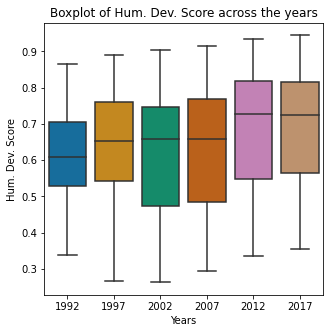

In [249]:
plt.figure(figsize=(5,5))
sns.boxplot(y='Hum.Dev', 
            x='Dis_Year', 
            data=merged2, 
            palette="colorblind")

plt.title("Boxplot of Hum. Dev. Score across the years")
plt.xlabel("Years")
plt.ylabel("Hum. Dev. Score")
plt.show()

#### Boxplot of Hum. Dev. Score across the years including migration trends
By displaying the Hum. Dev. Score against years while highlighting emigration (0) and immigration (1) as a boxplot helps to identify annual trends and differences across years.

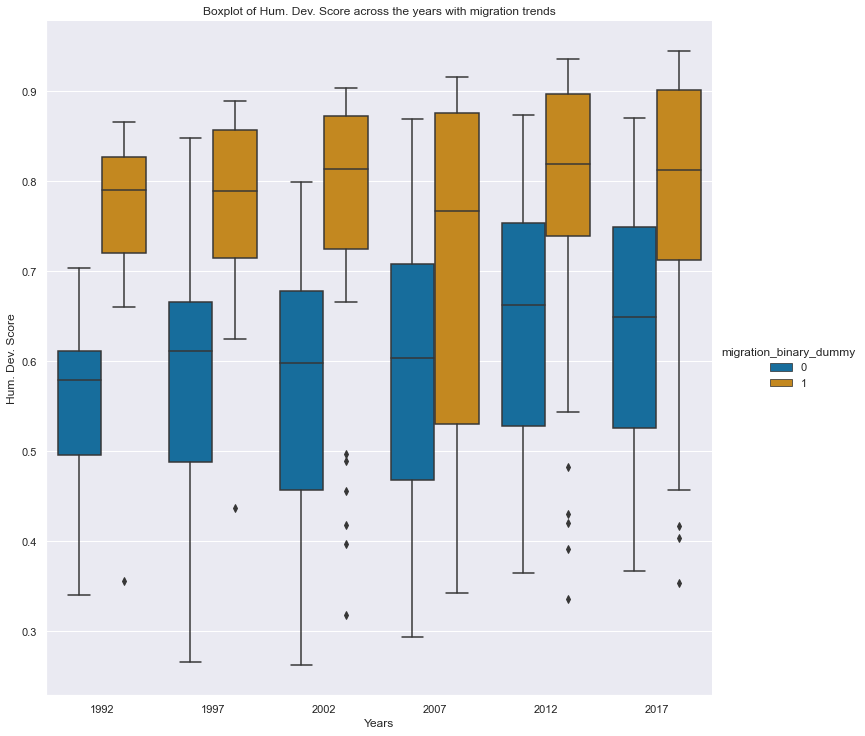

In [254]:
sns.catplot(x="Dis_Year", 
            y="Hum.Dev", 
            hue="migration_binary_dummy",
            data=merged2,
            kind="box",
            palette="colorblind",
            height=10, 
            aspect=1)

plt.title("Boxplot of Hum. Dev. Score across the years with migration trends")
plt.xlabel("Years")
plt.ylabel("Hum. Dev. Score")
plt.show()

#### Boxplot of Relative Migration by Number of Floods

We are hypothesizing that more severe weather will increase emigration, so we examine whether relative migration (net migration as a percent of the country's population) changes with the number of floods, since that was the most common disaster type.

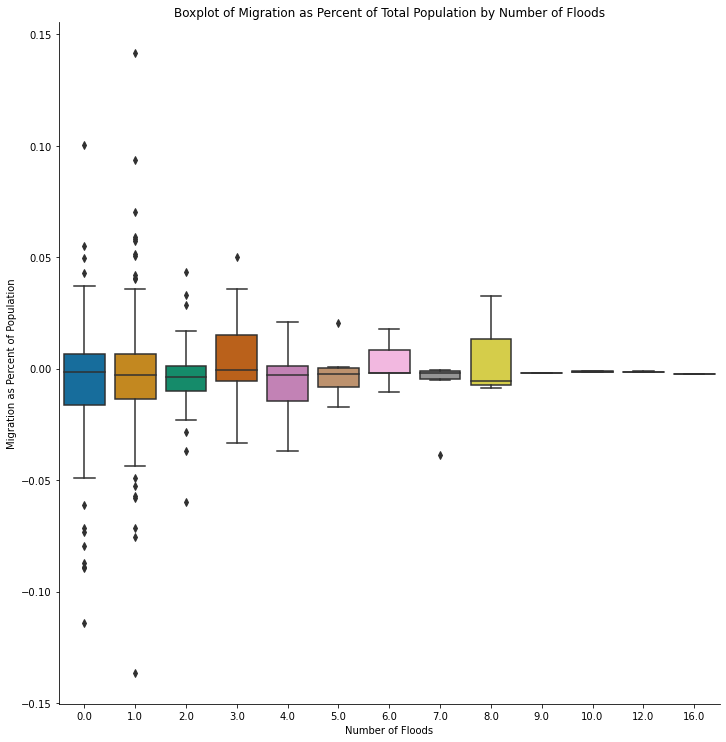

In [151]:
sns.catplot(x="disastertype_flood", 
            y="rel.migration", 
            #hue="Dis_Year",
            data=merged2,
            kind="box",
            palette="colorblind",
            height=10, 
            aspect=1)

plt.title("Boxplot of Migration as Percent of Total Population by Number of Floods")
plt.xlabel("Number of Floods")
plt.ylabel("Migration as Percent of Population")
plt.show()

#### Distribution plot of Hum. Dev. Score
Displaying the Hum. Dev. score distribution is valuable information. It is helpful in identifying potential outliers, determine if the data is normally distributed and other features that may not be seen without showing the data visually.

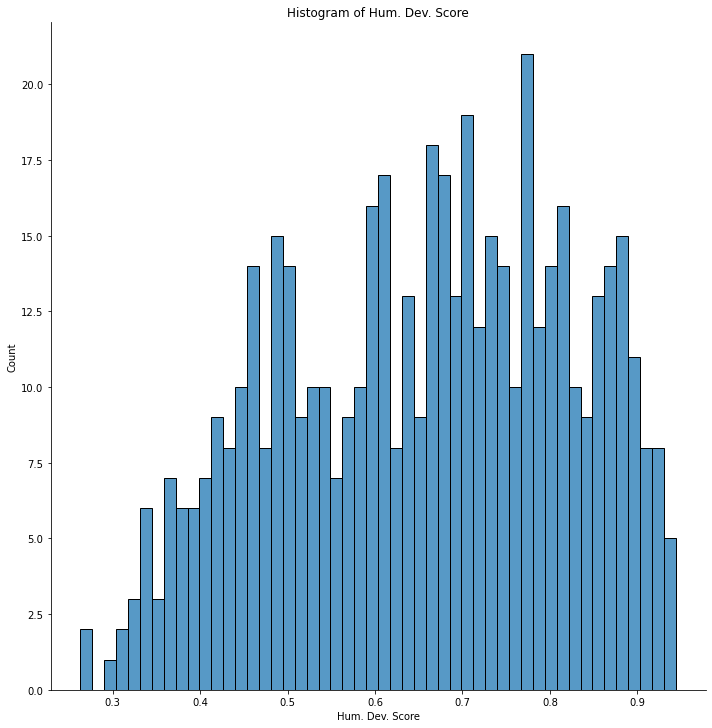

In [152]:
sns.displot(merged2["Hum.Dev"], 
            bins=50,
            height=10, 
            aspect=1)

plt.title("Histogram of Hum. Dev. Score")
plt.xlabel("Hum. Dev. Score")
plt.show()

#### Correlation Matrix of the predictors
A heatmap allows us to display a correlation matrix visually. Here, the higher the absolute value, the more the variables are correlated to one another.

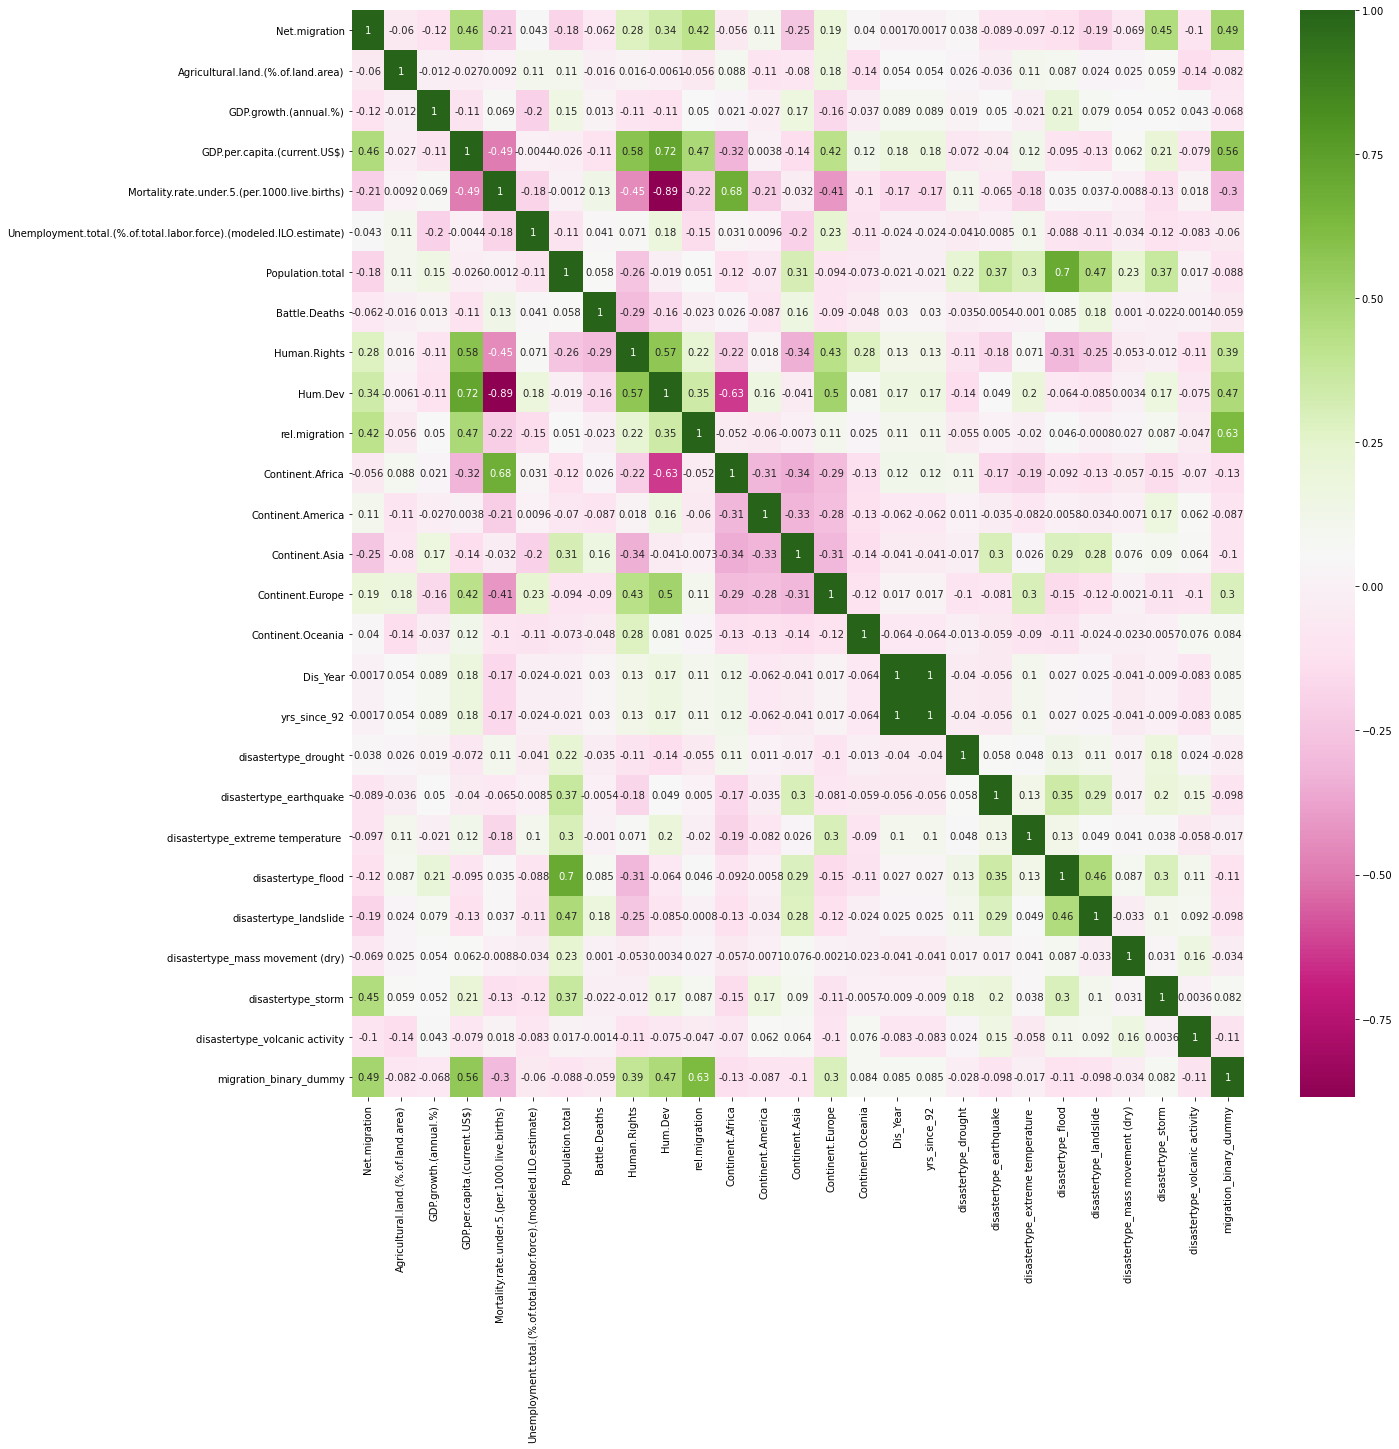

In [153]:
#Correlation plot to check for multicollinearity issues
plt.figure(figsize=(20,20))
sns.heatmap(merged2.corr(), 
            annot = True, 
            cmap="PiYG")
plt.show()

## Question 1 - Classify which countries will see immigration vs. emigration due to climate disasters.

Our target variable is net migration, recoded into a binary variable to indicate whether net migration was negative (emigration) or positive (immigration). The remaining variables were added as features other than identification variables, and then the X and y dataframes split into training and testing sets with a 75/25 split.

In [154]:
# Train a KNN Classifier model.
# First, set target variable and features, then split into train and test sets.

y = merged2['migration_binary_dummy']
X = merged2.drop(columns=['migration_binary_dummy', 'id','Dis_Country','Dis_Year', 'Net.migration','rel.migration'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=2)

print(X_test)

     Agricultural.land.(%.of.land.area)  GDP.growth.(annual.%)  \
396                           13.158436               4.024086   
268                           38.111944               6.796826   
5                             27.764598              -0.466913   
319                           57.687096               2.202939   
228                           27.478817               6.069871   
..                                  ...                    ...   
23                             7.209705               5.559858   
423                           44.225146               6.203489   
109                           85.390241               8.547683   
301                           64.258136              -1.175120   
285                           43.625385               3.070228   

     GDP.per.capita.(current.US$)  \
396                  15420.874541   
268                   1630.388906   
5                     2596.919876   
319                   7496.294648   
228                   

### 
### Q1 - Feature Selection

Before testing different models, we performed feature selection using the feature importance metrics from a Random Forest Classifier.

In [155]:
# Build a Random Forest Classifier
rfc = RandomForestClassifier().fit(X_train, y_train)

# Create predictions to generate a confusion matrix and classification report
rfcpreds = rfc.predict(X_test)
print(classification_report(y_test, rfcpreds))

              precision    recall  f1-score   support

           0       0.86      0.98      0.92        84
           1       0.94      0.71      0.81        45

    accuracy                           0.88       129
   macro avg       0.90      0.84      0.86       129
weighted avg       0.89      0.88      0.88       129



In [156]:
imports = pd.Series(rfc.feature_importances_)

#create dataframe of features and their importance score
features = pd.Series(list(X_train.columns))
df = pd.concat([features,imports], axis=1)
print(df)

                                                    0         1
0                  Agricultural.land.(%.of.land.area)  0.069692
1                               GDP.growth.(annual.%)  0.077646
2                        GDP.per.capita.(current.US$)  0.194658
3       Mortality.rate.under.5.(per.1000.live.births)  0.132151
4   Unemployment.total.(%.of.total.labor.force).(m...  0.075477
5                                    Population.total  0.068882
6                                       Battle.Deaths  0.023985
7                                        Human.Rights  0.087147
8                                             Hum.Dev  0.120674
9                                    Continent.Africa  0.010773
10                                  Continent.America  0.009226
11                                     Continent.Asia  0.006832
12                                   Continent.Europe  0.018317
13                                  Continent.Oceania  0.002446
14                                      

<AxesSubplot:xlabel='1', ylabel='0'>

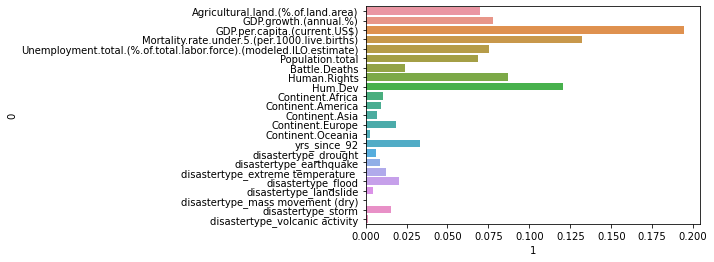

In [157]:
#plot feature importance in a bar chart
sns.barplot(x=1, y=0, data=df)

From the above exercise, we can see that certain features come up as highly important. These are largely features that we would expect, such as GDP and human development score, as well as some interesting ones such as Agricultural land as a percent of land area. Seeing that there appears to be a noticeable dichotomy between those with importance < .04 vs > .04, .04 seems like a good choice for a cut-off point. Since we also want to include Years Since 1992 from a theoretical standpoint, however, I use a cut-off of .03 in the next cell to conveniently grab all the features > .04 plus the desired yrs_since_92 variable.

In [158]:
# Print features with importance greater than .03

df_important = df[df[1] > .03]
df_important

,0,1
0,Agricultural.land.(%.of.land.area),0.069692
1,GDP.growth.(annual.%),0.077646
2,GDP.per.capita.(current.US$),0.194658
3,Mortality.rate.under.5.(per.1000.live.births),0.132151
4,Unemployment.total.(%.of.total.labor.force).(m...,0.075477
5,Population.total,0.068882
7,Human.Rights,0.087147
8,Hum.Dev,0.120674
14,yrs_since_92,0.032959


Lastly, we of course want to include all disaster variables in the model in order to examine how they impact migration, so we add these to the list of features to include in the final X dataframe.

In [159]:
# Extract final features to use for classifier models

final_features = list(df_important[0])
disasters = ['disastertype_drought',
                       'disastertype_earthquake',
                       'disastertype_extreme temperature ',
                       'disastertype_flood',
                       'disastertype_landslide',
                       'disastertype_mass movement (dry)',
                       'disastertype_storm', 
                       'disastertype_volcanic activity']

for d in disasters:
    final_features.append(d)


In [160]:
final_features

['Agricultural.land.(%.of.land.area)',
 'GDP.growth.(annual.%)',
 'GDP.per.capita.(current.US$)',
 'Mortality.rate.under.5.(per.1000.live.births)',
 'Unemployment.total.(%.of.total.labor.force).(modeled.ILO.estimate)',
 'Population.total',
 'Human.Rights',
 'Hum.Dev',
 'yrs_since_92',
 'disastertype_drought',
 'disastertype_earthquake',
 'disastertype_extreme temperature ',
 'disastertype_flood',
 'disastertype_landslide',
 'disastertype_mass movement (dry)',
 'disastertype_storm',
 'disastertype_volcanic activity']

Below we filter the X_train and X_test datasets to include only the final selected features. These are the X datasets that will be used to tune all three models.

In [161]:
X_train2 = X_train[final_features]
X_test2 = X_test[final_features]

### 
### Q1 - Model One: K-Nearest Neighbors

We start by fitting and tuning a K-Nearest Neighbors (KNN) model. This theoretically makes sense since KNN is not affected by interdependence between observations. While the observations are spaced out by five year intervals, there could still be some clustering by time as well as geography (e.g. some disasters affected more than one country). We start by fitting a KNN model using the default parameter of 5 neighbors and printing out the confusion matrix and classification report.

In [162]:
# Create, define, and fit a KNN Classifier.
knn = KNeighborsClassifier()
knn.fit(X_train2, y_train)

# Predict y_test values with the model using X_test.
knn_preds = knn.predict(X_test2)

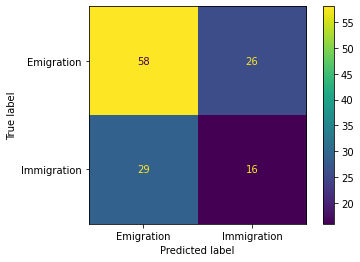

              precision    recall  f1-score   support

           0       0.67      0.69      0.68        84
           1       0.38      0.36      0.37        45

    accuracy                           0.57       129
   macro avg       0.52      0.52      0.52       129
weighted avg       0.57      0.57      0.57       129



In [163]:
# Create and display a confusion matrix for the predictions compared to true values
knn_cm = confusion_matrix(y_test, knn_preds)
ConfusionMatrixDisplay(confusion_matrix = knn_cm, display_labels=['Emigration', 'Immigration']).plot()
plt.show()

# Print the classification report
print(classification_report(y_test, knn_preds))

The KNN model had an accuracy of .57 for identifying which countries would experience net emigration versus net immigration in a given year. This is a fairly low accuracy, only slightly better than chance (.5). The average precision, recall and f1 score were also fairly low as all three were .52. The model produced roughly equal numbers of false positives and false negatives. It was more likely to classify an event as emigration than immigration. The model could likely be improved through cross-validation to find the optimal number of neighbors. Low sample sizes may also be hindering the predictive capability of the model.

### Q1 - KNN Cross Validation

Next we will use cross validation to find the optimal number of neighbors for the model based on which number will minimize mean squared error (MSE). We start by measuring mean MSE for a range of neighbors from 1 to 20 and graphing mean MSE against number of neighbors.

In [164]:
# Create an empty list that will contain the average accuracy for each number of neighbors.
CV = []
neighbors = range(1,21)
for i in neighbors:
    KNN = KNeighborsClassifier(n_neighbors=i) # Create KNN object with increasing number of neighbors.
    KNN = KNN.fit(X_train2, y_train) # Fit the model with each new number of neighbors.
    score = cross_val_score(KNN, X_train2, y_train, scoring = 'accuracy', cv = 10) # Calculate accuracy for each cross-validation.
    CV.append(score.mean()) # Store average accuracy from each number of neighbors.

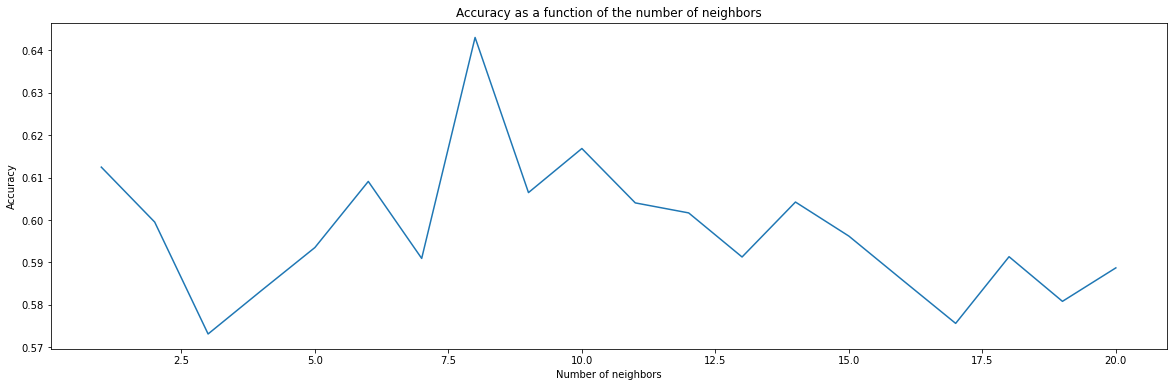

In [165]:
# Set up parameters for the plot appearance.
plt.figure(figsize=(20, 6))
plt.subplot(111)
ax = plt.gca()

# Input X, y data
ax.plot(neighbors, CV)

# label the Axes and Title
plt.xlabel("Number of neighbors")
plt.ylabel("Accuracy")
plt.title("Accuracy as a function of the number of neighbors")
plt.axis("tight")

#Display the plot.
plt.show()

In [166]:
print("Minimum CV error:", min(CV))
print("Number of neighbors at minimum CV:",CV.index(min(CV)) + 1)

Minimum CV error: 0.5731443994601889
Number of neighbors at minimum CV: 3


We find that the minimum MSE occurs at 3 neighbors, so we will re-train the KNN model with only 3 neighbors as the parameter.

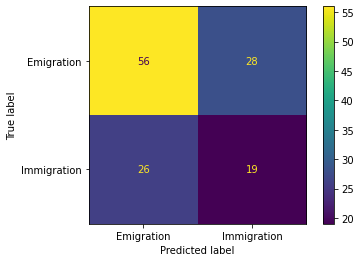

In [167]:
# Build a KNN object with number of neighbors set to 4.
KNN = KNeighborsClassifier(n_neighbors=3)

# Fit the data to the KNN object.
KNN.fit(X_train2, y_train)

# Use the model to predict y values for the X_test data.
preds = KNN.predict(X_test2)

# Create a confusion matrix to compare the predicted y values to the actual y values from the test data.
conmat = confusion_matrix(y_test, preds)

# Display the confusion matrix.
ConfusionMatrixDisplay(confusion_matrix=conmat, display_labels = ['Emigration','Immigration']).plot()
plt.show()

In [168]:
# Display a classification report with accuracy, recall, f1-score and precision values.
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.68      0.67      0.67        84
           1       0.40      0.42      0.41        45

    accuracy                           0.58       129
   macro avg       0.54      0.54      0.54       129
weighted avg       0.59      0.58      0.58       129



Unfortunately, even with cross-validation, the model's accuracy only improved by one percentage point. Precision, recall, and f1-score simiarly only improved by two percentage points. The model is still not a strong predictor of migration and performs only slightly better than a coin flip.

### 
### Q1 - Model Two: Random Forest Classifier

Next we try a Random Forest Classifier. We already saw during feature selection that it could perform well at predicting migration (accuracy of .88), so we will try fitting it again but this time with only the selected features. We will start by building a model with SK Learn's default parameters.

In [169]:
# Build a Random Forest Classifier
rfc = RandomForestClassifier().fit(X_train2, y_train)

# Create predictions to generate a confusion matrix and classification report
rfcpreds = rfc.predict(X_test2)
print(classification_report(y_test, rfcpreds))

              precision    recall  f1-score   support

           0       0.87      0.98      0.92        84
           1       0.94      0.73      0.83        45

    accuracy                           0.89       129
   macro avg       0.91      0.85      0.87       129
weighted avg       0.90      0.89      0.89       129



Not too surprisingly, the model performed about the same as during feature selection since the only thing we changed was taking out some of the less important features. Next, however, we will use GridSearchCV to tune multiple paramters simultaneously to optimize the model and reduce error. The parameters we selected to tune are n_estimators (the number of trees it creates), max_depth (the maximum number of levels, or the number of splits + 1), and min_samples_split (the minimum number of observations required for a split to occur).

In [170]:
# Set the parameters and model
parameters = {'n_estimators': range(20,401,40), 
              'max_depth': range(5,9), 
              'min_samples_split':range(6,11)}
model = RandomForestClassifier(random_state=1)

# Tune the parameters using GridSearchCV
GS_CV = GridSearchCV(estimator=model, param_grid=parameters)

In [171]:
# Fit a model with the best parameters from GridSearch CV
best_model = GS_CV.fit(X_train2, y_train)

In [172]:
# Extract the chosen parameters
best_est = best_model.best_params_
print(best_est)

{'max_depth': 8, 'min_samples_split': 6, 'n_estimators': 100}


GridSearch CV suggested a max_depth of 8, min_samples_split of 6 and n_estimators of 100. We re-train the model using these tuned parameters.

              precision    recall  f1-score   support

           0       0.86      0.98      0.92        84
           1       0.94      0.71      0.81        45

    accuracy                           0.88       129
   macro avg       0.90      0.84      0.86       129
weighted avg       0.89      0.88      0.88       129



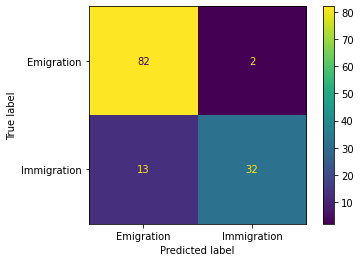

In [173]:
# Build a Random Forest Classifier
rfc = RandomForestClassifier(max_depth=8, min_samples_split=6, n_estimators=100, random_state=1).fit(X_train2, y_train)

# Create predictions to generate a confusion matrix and classification report
rfcpreds = rfc.predict(X_test2)
conmat_rfc = confusion_matrix(y_test, rfcpreds)
ConfusionMatrixDisplay(confusion_matrix = conmat_rfc, display_labels = ['Emigration','Immigration']).plot()
print(classification_report(y_test, rfcpreds))

Using the parameters from GridSearchCV, the model remained about the same but still performed highly. Accuracy was .88, and average precision, recall, and f1 score were .90, .84, and .86, respectively. This model was also much better at correctly predicting events ("Immigration"), whereas KNN had more false negatives.

### 
### Q1 - Model Three: Gaussian Naive Bayes

Lastly we fit a Gaussian Naive Bayes model to compare against the random forest. This model does not have parameters for us to tune, so we display the default model and results.

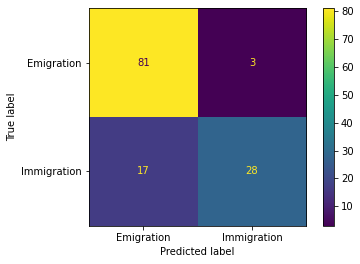

In [174]:
# Create a Gaussian Naive Bayes object.
nb = GaussianNB()

# Fit the training data to the model and then use the model to predict the y values for the X_test data.
preds = nb.fit(X_train2, y_train).predict(X_test2)

# Create a confusion matrix to compare the predicted y values to the actual y values from the test data.
cm_nb = confusion_matrix(y_test, preds)

# Display the confusion matrix.
ConfusionMatrixDisplay(confusion_matrix = cm_nb, display_labels = ['Emigration','Immigration']).plot()
plt.show()

In [175]:
# Display a classification report with accuracy, recall, f1-score and precision values.
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.83      0.96      0.89        84
           1       0.90      0.62      0.74        45

    accuracy                           0.84       129
   macro avg       0.86      0.79      0.81       129
weighted avg       0.85      0.84      0.84       129



Naive Bayes performed similarly to the Random Forest Classifier, coming in just shy of the RFC's results with an accuracy of .84 and average precision, recall, and f1 score of .86, .79 and .81, respectively.

Given the above results, we would choose the tuned Random Forest Classifier for our final model.

In [176]:
# Create new training and testing sets with 2018 data as the test and pre-2018 data as the training.
y = merged2[['migration_binary_dummy', 'yrs_since_92']]
X = merged2.drop(columns=['migration_binary_dummy', 'id','Dis_Country','Dis_Year', 'Net.migration','rel.migration'])

X_train = X[X['yrs_since_92'] < 25]
X_test = X[X['yrs_since_92'] == 25]
y_train = y[y['yrs_since_92'] < 25]
y_test = y[y['yrs_since_92'] == 25]

X_pre_2018 = X_train.copy()
X_2018 = X_test.copy()
y_pre_2018 = y_train.copy()
y_2018 = y_test.copy()
y_pre_2018.drop(columns = 'yrs_since_92', inplace=True)
y_2018.drop(columns = 'yrs_since_92', inplace=True)

print(y_2018)

     migration_binary_dummy
434                       0
438                       1
437                       1
439                       1
453                       0
..                      ...
436                       0
431                       1
430                       0
433                       1
426                       1

[98 rows x 1 columns]


In [177]:
# Build a Random Forest Classifier using the parameters selected by GridSearchCV
# Fit to pre-2018 data
rfc = RandomForestClassifier(max_depth=8, min_samples_split=6, n_estimators=100, random_state=1).fit(X_pre_2018, y_pre_2018.values.ravel())

# Create predictions
rfcpreds = rfc.predict(X_2018)

## Question 2 - Predicting whether net ODA is increasing with increasing disaster frequency

In order to determine whether net ODA (overseas development assistance) increases with the number of disasters a country experiences in a year, we select the regression model that is most predictive of net ODA, fit it to the training data, and examine the coefficient (beta) on total disasters to see whether it is positive and statistically significant. This would indicate that net ODA increases with disaster frequency. The other features are included in the model as controls.

We start by creating a new merged dataset since net ODA was dropped during the initial merge.

### Q2 - New Dataset Merge for Using ODA as the Target Variable

In [178]:
migration3 = migration.drop(columns=['Access.to.electricity.(%.of.population)', 'Dem.Index']) #Redo merge since ODA was dropped before

migration3.dropna(inplace=True)

In [179]:
migration3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 654 entries, 9 to 2400
Data columns (total 20 columns):
 #   Column                                                              Non-Null Count  Dtype  
---  ------                                                              --------------  -----  
 0   Country.Name                                                        654 non-null    object 
 1   Country.Code                                                        654 non-null    object 
 2   Year                                                                654 non-null    int64  
 3   Net.migration                                                       654 non-null    int64  
 4   Agricultural.land.(%.of.land.area)                                  654 non-null    float64
 5   Net.ODA.received.(%.of.GNI)                                         654 non-null    float64
 6   GDP.growth.(annual.%)                                               654 non-null    float64
 7   GDP.per.capita.(

In [180]:
merged3 = migration3.merge(right = disasters_final, how = 'inner', left_on = ['Country.Name', 'Year'], right_on = ['Dis_Country', 'Dis_Year'])
merged3.sort_values(by='id',inplace=True)
print(len(merged3))

375


In [181]:
merged3_dropped = merged3.drop_duplicates()
print(len(merged3_dropped)) # Confirm there were no duplicate rows

merged3.isna().sum().sum() # Confirm there are no null values

375


0

In [182]:
merged3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 375 entries, 121 to 238
Data columns (total 32 columns):
 #   Column                                                              Non-Null Count  Dtype  
---  ------                                                              --------------  -----  
 0   Country.Name                                                        375 non-null    object 
 1   Country.Code                                                        375 non-null    object 
 2   Year                                                                375 non-null    int64  
 3   Net.migration                                                       375 non-null    int64  
 4   Agricultural.land.(%.of.land.area)                                  375 non-null    float64
 5   Net.ODA.received.(%.of.GNI)                                         375 non-null    float64
 6   GDP.growth.(annual.%)                                               375 non-null    float64
 7   GDP.per.capita.

In [183]:
merged3 = merged3.drop(columns = ['Country.Name', 'Country.Code', 'Year', 'id', 'Dis_Country' ]) # Drop redundant columns

### Q2 - Combine Disaster Types into Singular Disaster Count

We create a new column to capture the total number of disasters of all types in a country in a year and drop the columns for individual disasters.

In [184]:
# Add values of disaster columns
merged3['total_disasters'] = merged3['disastertype_drought'] + merged3['disastertype_earthquake'] + merged3['disastertype_extreme temperature '] + merged3['disastertype_flood'] + merged3['disastertype_landslide'] + merged3['disastertype_mass movement (dry)'] + merged3['disastertype_storm'] + merged3['disastertype_volcanic activity']

In [185]:
# Drop the columns for individual disasters
merged3 = merged3.drop(columns = ['disastertype_drought', 'disastertype_earthquake', 'disastertype_extreme temperature ', 'disastertype_flood', 'disastertype_landslide', 'disastertype_mass movement (dry)','disastertype_storm', 'disastertype_volcanic activity'])

We split this new merged dataset into X and y and then into testing and training sets.

In [186]:
y_oda = merged3['Net.ODA.received.(%.of.GNI)'] # Create y 
X_oda = merged3.drop(columns = ['Net.ODA.received.(%.of.GNI)']) # Create X

In [187]:
# Split into testing and training
Xo_train, Xo_test, yo_train, yo_test = train_test_split(X_oda, y_oda, test_size=0.25, random_state=1)

### Q2 - Fitting Three Regression Models: Ridge, Lasso and Linear

We tune and fit a linear regression model and two regularized regression models to the training data.

The Ridge and Lasso regressions are tuned using RidgeCV and LassoCV, which determine the best alpha through cross-validation. Feature selection is done automatically in the case of a Lasso regression, and Ridge approximates feature selection by restricting the coefficients, often bringing the least significant coefficients close to zero.

In [188]:
#Fit and tune Ridge regression model
ridge = RidgeCV(cv=10, alphas=np.logspace(-5,5,200), normalize=True).fit(Xo_train, yo_train)

In [189]:
#Fit and tune Lasso regression model
lasso = LassoCV(cv=10, alphas=np.logspace(-5,5,200), normalize=True).fit(Xo_train, yo_train)

In [190]:
#Fit Linear regression model
lm = LinearRegression(normalize=True).fit(Xo_train, yo_train)

We also check to see whether to transform the linear model to polynomial by examining the training and testing MSE for degrees 1 through 5.

In [191]:
for i in range(1,6): #Check for optimal degree
    lr = LinearRegression(normalize=True) #New LinearRegression object
    p = PolynomialFeatures(degree=i) #PolynomialFeatures object for degree in question
    X_train_new = p.fit_transform(Xo_train) #Transform the training set to incorporate n-degree polynomials
    X_test_new = p.fit_transform(Xo_test) #Transform the test set to incorporate n-degree polynomials
    lr.fit(X_train_new, yo_train) #Fit n-degree model 
    y_pred_train = lr.predict(X_train_new) #Generate predicted values for new training set
    y_pred_test = lr.predict(X_test_new) #Generate predicted values for new test set
    
    print('Training MSE for degree', i, ': ', mean_squared_error(yo_train, y_pred_train))
    print('Testing  MSE for degree', i, ': ', mean_squared_error(yo_test, y_pred_test))
    print('\n')

Training MSE for degree 1 :  57.34653658101851
Testing  MSE for degree 1 :  35.022498273471015


Training MSE for degree 2 :  127.94503756921921
Testing  MSE for degree 2 :  1.4141202337092458e+26


Training MSE for degree 3 :  2.656820192900871e-26
Testing  MSE for degree 3 :  12706.497248048981


Training MSE for degree 4 :  1.2164127176912642e-26
Testing  MSE for degree 4 :  23337.55149895939


Training MSE for degree 5 :  3.8126720146342824e-26
Testing  MSE for degree 5 :  35720.30447439831




The training MSE increases dramatically with each new degree, so we will stick to degree 1.

### Q2 - Cross Validation
We now carry out 10-fold cross-validation to determine which model to select.

In [192]:
# Print CV scores 
CV_Ridge = np.mean(cross_val_score(ridge, Xo_train, yo_train, cv=10, scoring='neg_mean_squared_error'))
CV_Lasso = np.mean(cross_val_score(lasso, Xo_train, yo_train, cv=10, scoring='neg_mean_squared_error'))
CV_Lin = np.mean(cross_val_score(lm, Xo_train, yo_train, cv=10, scoring='neg_mean_squared_error'))

In [193]:
print('CV error with Ridge regression', CV_Ridge*(-1))
print('CV error with Lasso regression', CV_Lasso*(-1))
print('CV error with linear regression', CV_Lin*(-1))

CV error with Ridge regression 78.21747391286432
CV error with Lasso regression 75.11573693035584
CV error with linear regression 82.35237321611615


Since the Lasso regression has the lowest CV error, it is the most predictive of net ODA. We will use it for the analysis.

In [194]:
# Display coefficients
# Display coefficients
for i in range(len(Xo_test.columns)):
    print('The coefficient on', Xo_test.columns[i], 'is', lasso.coef_[i], '\n')

The coefficient on Net.migration is 1.3117911365503458e-06 

The coefficient on Agricultural.land.(%.of.land.area) is -0.003330252064995779 

The coefficient on GDP.growth.(annual.%) is 0.0 

The coefficient on GDP.per.capita.(current.US$) is -0.0 

The coefficient on Mortality.rate.under.5.(per.1000.live.births) is 0.0 

The coefficient on Unemployment.total.(%.of.total.labor.force).(modeled.ILO.estimate) is -0.0 

The coefficient on Population.total is -0.0 

The coefficient on Battle.Deaths is 0.00013076906816108586 

The coefficient on Human.Rights is 1.4644189855018093 

The coefficient on Hum.Dev is -32.55768826032056 

The coefficient on rel.migration is -63.38429963973812 

The coefficient on Continent.Africa is 0.0 

The coefficient on Continent.America is -0.0 

The coefficient on Continent.Asia is -0.0 

The coefficient on Continent.Europe is 2.679924059391934 

The coefficient on Continent.Oceania is 0.0 

The coefficient on Dis_Year is -0.0 

The coefficient on yrs_since_9

The coefficient on total disasters is 0 (it was dropped by the model). There appears to be no significant relationship between disaster frequency and net ODA. Countries with an increasing frequency of disasters are currently not receiving more overseas development aid.

## Question 3 - GDP Prediction  
- In this section, we develop models to predict impacts to GDP score based on migration and climate disasters.
- For this 'GDP.per.capita.(current.US$)' is the target variable. 
- For this analysis, a number of predictors are removed from the dataset because the are correlated to one another and could impact the analysis in a negative way. 
- The following predictors are removed: 'GDP.growth.(annual.%)', 'rel.migration', 'id', 'Dis_Country', 'yrs_since_92', 'migration_binary_dummy'.

In [195]:
#Splitting the dataframe
X = merged2.drop(columns = ['GDP.growth.(annual.%)', 'GDP.per.capita.(current.US$)', 'rel.migration', 
                             'id', 'Dis_Country', 'yrs_since_92', 'migration_binary_dummy'], axis = 1)
y = merged2['GDP.per.capita.(current.US$)']

#Splitting into X_train, X_test, y_train and y_test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

#print(y_test)

In [196]:
#Linear Regression
lm = LinearRegression(normalize=True)

#Fit LR on training data
lm.fit(X_train, y_train)

#Use LR to predict trainig & testing test observations
y_pred_train = lm.predict(X_train)
y_pred_test = lm.predict(X_test)

#Printing out R-squared & MSEs
print("Training R-squared: ",round(lm.score(X_train, y_train), 4))
print("Testing R-squared:  ",round(lm.score(X_test, y_test), 4))
print()

print("Training MSE:       ",round(mean_squared_error(y_train, y_pred_train), 4))
print("Test MSE:           ",round(mean_squared_error(y_test, y_pred_test), 4))

Training R-squared:  0.7223
Testing R-squared:   0.613

Training MSE:        53080444.3807
Test MSE:            62122409.7444


The model is not a great fit. As expected, the Test MSE is higher than the train MSE, however, both are very large.

#### Linear Regression with CV
- Iterating through all possible number of features
- Calculating Avg CV errors for each
- Selecting min Error

Through feature selection, we can identify the optimal number of predictors from the given ones for the smallest CV error and therefore identify the best model.

In [197]:
#Linear Regression Model
model= LinearRegression(normalize=True)

#Empty List
cv_errors =[]

for i in range(1, X_train.shape[1]):
    
    k=10
    sfs = SequentialFeatureSelector(model, 
                                    n_features_to_select = i, #number of features to use
                                    direction="forward",
                                    scoring='neg_mean_squared_error',
                                    cv= k) #number of folds
    sfs = sfs.fit(X_train,y_train)
    
    #Column names from dataframe
    feature_names= X_train.columns
    #Column data from dataframe
    features = X_train[feature_names[sfs.get_support()]]
    
    #Cross_val_score for this regression model
    cvs = cross_val_score(model, features, y_train, cv=k, scoring='neg_mean_squared_error')
    cvs_mean = cvs.mean() * -1 #make positive
    cv_errors.append(cvs_mean) #append list
    
    #Print Features & Output
    print("Number of features selected:", i)
    print("Features selected by forward sequential selection: ")
    for p in range(i):
        print(str(feature_names[sfs.get_support()][p]))
    print("Avg. CV Error:", str(round(cvs_mean, 4)))
    print()

Number of features selected: 1
Features selected by forward sequential selection: 
Hum.Dev
Avg. CV Error: 89474150.879

Number of features selected: 2
Features selected by forward sequential selection: 
Mortality.rate.under.5.(per.1000.live.births)
Hum.Dev
Avg. CV Error: 70529416.7803

Number of features selected: 3
Features selected by forward sequential selection: 
Net.migration
Mortality.rate.under.5.(per.1000.live.births)
Hum.Dev
Avg. CV Error: 64164881.6759

Number of features selected: 4
Features selected by forward sequential selection: 
Net.migration
Mortality.rate.under.5.(per.1000.live.births)
Human.Rights
Hum.Dev
Avg. CV Error: 60994909.983

Number of features selected: 5
Features selected by forward sequential selection: 
Net.migration
Mortality.rate.under.5.(per.1000.live.births)
Unemployment.total.(%.of.total.labor.force).(modeled.ILO.estimate)
Human.Rights
Hum.Dev
Avg. CV Error: 58344896.23

Number of features selected: 6
Features selected by forward sequential selection

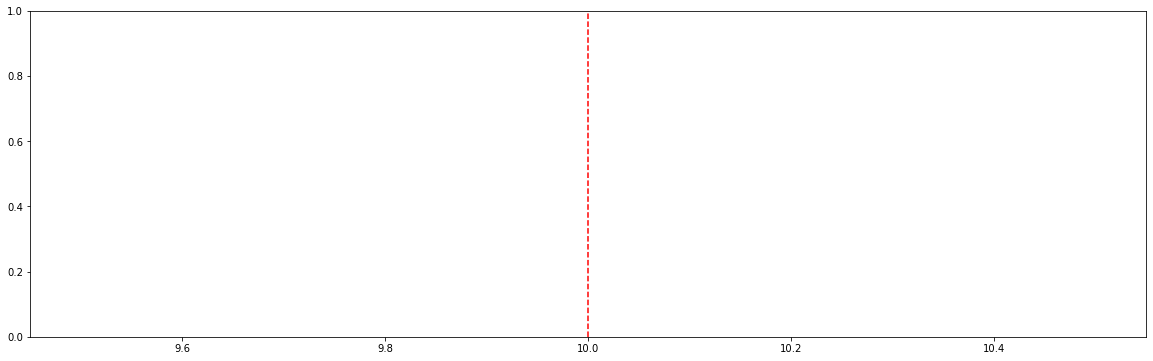

In [198]:
#Plot Size
plt.figure(figsize=(20,6))

#Predictor Range
predictors = range(1, X_train.shape[1])

#Calculating Min Error from Average Errors
min_error = min(cv_errors)

#Printing Vertical Line
plt.axvline(predictors[cv_errors.index(min_error)], color='r', linestyle='--')

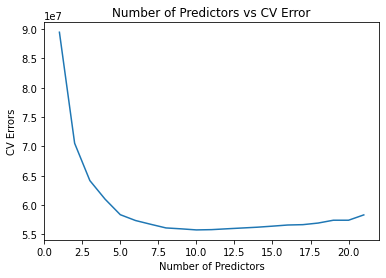

Number of Predictors that corresponds to the lowest CV Error: 10
Lowest CV Error: 55746842.3704


In [199]:
#Graphing Plot
plt.subplot(111)
ax = plt.gca()
ax.plot(predictors, cv_errors)
plt.xlabel("Number of Predictors")
plt.ylabel("CV Errors")
plt.title("Number of Predictors vs CV Error")

plt.show()

#Printing #of Predictors & the corresponding min Error
print("Number of Predictors that corresponds to the lowest CV Error:", predictors[cv_errors.index(min_error)])
print("Lowest CV Error:", round(min_error, 4))

As shown, the following 10 predictors lead to the lowest CV Error of  55746842.37:
- Net.migration
- Mortality.rate.under.5.(per.1000.live.births)
- Unemployment.total.(%.of.total.labor.force).(modeled.ILO.estimate)
- Population.total
- Battle.Deaths
- Human.Rights
- Hum.Dev
- Continent.America
- disastertype_earthquake
- disastertype_volcanic activity

#### Ridge Regression
- Ridge Regression to perform feature selection.
- This will shrink the $\hat{\beta}$ coefficients close to zero.

In [200]:
model_ridge_cv = RidgeCV(cv=10, alphas=np.logspace(-5,5,200), normalize=True).fit(X_train, y_train)

#### Lasso Regression
- Lasso Regression to perform feature selection.
- This will shrink the $\hat{\beta}$ coefficients to zero.

In [201]:
model_lasso_cv = LassoCV(cv=10, alphas=np.logspace(-5,5,200), normalize=True).fit(X_train, y_train)

In [202]:
ridge_pred = model_ridge_cv.predict(X_test)
lasso_pred = model_lasso_cv.predict(X_test)

ridge_error = mean_squared_error(y_test, ridge_pred)
lasso_error = mean_squared_error(y_test, lasso_pred)

In [203]:
#Printing Linear Regression
print("Linear Regression:")
print("Number of Predictors corresponding to the lowest CV Error:", predictors[cv_errors.index(min_error)])
print("Lin. Regression - Min Error:", round(min_error, 4))
print()

#Printing Ridge Regression
print("Ridge regression error:", ridge_error)

#Printing Lasso Regression
print("Lasso regression error:", lasso_error)

Linear Regression:
Number of Predictors corresponding to the lowest CV Error: 10
Lin. Regression - Min Error: 55746842.3704

Ridge regression error: 62478178.7958102
Lasso regression error: 57946067.34129851


- Based on the results, all three regressions have errors very close to one another. Yet, the linear regression has the lowest error and is therefore the best model for this data.
- The linear regression is chosen for further analysis since the error is the lowest.

#### Validating & Re-training of the model
Since the linear regression with 10 predictors was chosen, this model is applied & trained to the data.

In [204]:
#New X & Y using only the ten selected predictors:
X2 = merged2[['Net.migration', 'Mortality.rate.under.5.(per.1000.live.births)', 
              'Unemployment.total.(%.of.total.labor.force).(modeled.ILO.estimate)', 'Population.total',
              'Battle.Deaths', 'Human.Rights', 'Hum.Dev', 'Continent.America', 'disastertype_earthquake', 
              'disastertype_volcanic activity']]
y2 = merged2['GDP.per.capita.(current.US$)']

#Splitting into X_train, X_test, y_train and y_test
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.25, random_state=1)

#New Linear Regression
lm2 = LinearRegression(normalize=True)
lm2.fit(X2_train, y2_train)

#Use New Regression to predict trainig & testing test observation & find R-squared values
y2_pred_train = lm2.predict(X2_train)
y2_pred_test = lm2.predict(X2_test)
print("Training R-squared: ", round(lm2.score(X2_train, y2_train), 4))
print("Testing R-squared:  ", round(lm2.score(X2_test, y2_test), 4))
print()
print("Training MSE:       ", round(mean_squared_error(y2_train, y2_pred_train), 4))
print("Test MSE:           ", round(mean_squared_error(y2_test, y2_pred_test), 4))

Training R-squared:  0.7178
Testing R-squared:   0.6269

Training MSE:        53944723.7195
Test MSE:            59886427.3173


Compared to the initial model and its fit, this model performs slightly better on the testing data with a lower testing MSE but a slightly larger training MSE. This could be due to a decreased amount of overfitting of the model onto the training data. 

The previous model:
- Training MSE:        53944723.7195
- Test MSE:            59886427.3173

#### GDP Prediction based on the selected indicators
Using the selected model, we predict the GDP for each country. 

In [205]:
# Creating new dataframes based on country, predicted GDP & actual GDP
df1 = merged2
df1 = df1[["Dis_Country"]]
df1 = df1.reset_index(drop=True)

df2 = y2_pred_test
df2 = pd.DataFrame(df2)

df3 = y2_test
df3 = pd.DataFrame(df3)
df3 = df3.reset_index(drop=True)

# Combining the three new dataframes
result = pd.concat([df1, round(df2,3), round(df3,3)], axis=1)
result.columns = ['Dis_Country', 'Predicted GDP.per.capita', 'Actual GDP.per.capita']

result.sort_values('Predicted GDP.per.capita', inplace=True, ascending=[False])

print(result.head(20))

            Dis_Country  Predicted GDP.per.capita  Actual GDP.per.capita
78         South Africa                 59575.891              31459.139
102              Greece                 45384.440              38023.161
110          Montenegro                 40254.783              43858.363
17                India                 33868.521              50566.827
111             Morocco                 33796.864              80449.995
117  Russian Federation                 31834.122              39982.754
34                Ghana                 31098.291              44543.041
96              Croatia                 28925.925              17025.532
58           Mauritania                 28836.333              17474.187
60           Mozambique                 27855.952              23468.597
67                 Oman                 26611.876              41508.434
2      Papua New Guinea                 25859.613              35275.228
11                Spain                 25390.082  

Using the sorting feature to do camparisons:
- For the highest 20 predicted GDPs, this model predicted GDP surprising well for 3 countries that are actually the highest 20. 
- Overall, the model did fairly well in predicting the GDP scores even with just 10 predictors.

## Conclusions

#### Which countries likely to experience immigration vs emigration based on the prevalence of different climate disasters and economic indicators?

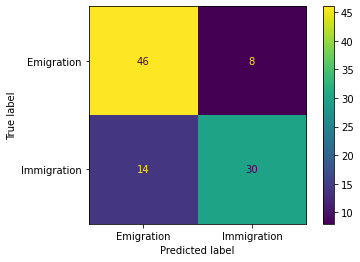

In [206]:
conmat_rfc = confusion_matrix(y_2018, rfcpreds)
ConfusionMatrixDisplay(confusion_matrix = conmat_rfc, display_labels = ['Emigration','Immigration']).plot()

In [207]:
print(classification_report(y_2018, rfcpreds))

              precision    recall  f1-score   support

           0       0.77      0.85      0.81        54
           1       0.79      0.68      0.73        44

    accuracy                           0.78        98
   macro avg       0.78      0.77      0.77        98
weighted avg       0.78      0.78      0.77        98



Based on data from the most recent year available, 2018, the random forest classifier we selected predicts that in the future, 54 countries will experience net immigration, and 44 countries will experience net emigration. This takes into account economic indicators and the frequency of disasters. These predictions should hold into the future assuming that the relative frequency of disasters in each country remains steady as the overall frequency increases.

#### Does net ODA (Official Development Assistance) increase with increasing disaster frequency? (I.e. are countries receiving the assistance they need to recover from climate disasters?)

In [208]:
for i in range(len(Xo_test.columns)):
    print(Xo_test.columns[i], 'coefficient: ', round(lasso.coef_[i],4))

Net.migration coefficient:  0.0
Agricultural.land.(%.of.land.area) coefficient:  -0.0033
GDP.growth.(annual.%) coefficient:  0.0
GDP.per.capita.(current.US$) coefficient:  -0.0
Mortality.rate.under.5.(per.1000.live.births) coefficient:  0.0
Unemployment.total.(%.of.total.labor.force).(modeled.ILO.estimate) coefficient:  -0.0
Population.total coefficient:  -0.0
Battle.Deaths coefficient:  0.0001
Human.Rights coefficient:  1.4644
Hum.Dev coefficient:  -32.5577
rel.migration coefficient:  -63.3843
Continent.Africa coefficient:  0.0
Continent.America coefficient:  -0.0
Continent.Asia coefficient:  -0.0
Continent.Europe coefficient:  2.6799
Continent.Oceania coefficient:  0.0
Dis_Year coefficient:  -0.0
yrs_since_92 coefficient:  -0.0
total_disasters coefficient:  0.0


The fitted and validated Lasso regression model we selected as the most predictive of net ODA indicates that there is no relationship between disaster frequency and net ODA. Based on this, we conclude that net ODA does not increase with increasing disaster frequency. As climate change accelerates, this problem requires attention as countries who suffer more disasters will need more aid.

#### How does GDP change in response to migration and climate disasters?

In [209]:
for i in range(len(X2_test.columns)):
    print(X2_test.columns[i], 'coefficient: ', round(lm2.coef_[i],4))

Net.migration coefficient:  0.0037
Mortality.rate.under.5.(per.1000.live.births) coefficient:  167.0935
Unemployment.total.(%.of.total.labor.force).(modeled.ILO.estimate) coefficient:  -282.6829
Population.total coefficient:  0.0
Battle.Deaths coefficient:  0.1252
Human.Rights coefficient:  1932.1273
Hum.Dev coefficient:  88010.5605
Continent.America coefficient:  -2141.3707
disastertype_earthquake coefficient:  -1201.0135
disastertype_volcanic activity coefficient:  2402.2211


Based on our fitted and validated linear regression model, net in-migration of 1,000 people is associated an increase in GDP per capita of just 3 USD when all other factors are held equal, which is a small but not negligible effect.

An earthquake occurring is associated with a decrease of around 1201 USD in GDP per capita, while a volcanic eruption occurring is associated with an increase of around 2402 USD in GDP per capita. No climate-related disasters are predictive of changes in GDP.

It is interesting to see that migration and climate disasters have such little correlation with GDP in general.

## Future Work

#### If we had more time:
* Acquire annual data to supplement the five-year increments used in this analysis
* Include more nuanced data for capturing climate impacts (e.g. harvest yields)

#### Improvements to the models:
* Attempt boosting on the Random Forest Classifier to improve performance

## Future Work

#### Paths we couldn’t take due to timing restrictions or data:
* Incorporating more climate data as predictors of migration and perhaps removing economic indicators, which could be overpowering any climate impacts

#### Constraints:
* Economic indicators, including GDP, are not always reliably measured throughout the world
* Only disasters of a certain scale were included in the disaster dataset (i.e. does not capture smaller extreme weather events)
* Certain disaster types were notably missing (e.g. hurricane, tornado, tsunami)
* Null values limited the size of the datasets, particularly for Question 2

## References
* https://chrisalbon.com/code/machine_learning/trees_and_forests/feature_selection_using_random_forest/
* https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sort_index.html
* https://stackoverflow.com/questions/54307300/what-causes-indexing-past-lexsort-depth-warning-in-pandas
* https://seaborn.pydata.org/generated/seaborn.heatmap.html
* https://seaborn.pydata.org/generated/seaborn.displot.html
* https://seaborn.pydata.org/generated/seaborn.boxplot.html
* https://seaborn.pydata.org/generated/seaborn.boxplot.html
* https://seaborn.pydata.org/generated/seaborn.boxplot.html
* https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html
* https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop_duplicates.html
* https://stackoverflow.com/questions/51459651/drop-duplicates-keeping-the-row-with-the-highest-value-in-another-column
* https://stackoverflow.com/questions/24502500/python-matplotlib-getting-rid-of-matplotlib-mpl-warning
* https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.replace.html
* https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html#pandas.DataFrame.merge
* https://stackoverflow.com/questions/13035764/remove-pandas-rows-with-duplicate-indices
* https://jakevdp.github.io/PythonDataScienceHandbook/03.05-hierarchical-indexing.html
* https://thispointer.com/pandas-sum-rows-in-dataframe-all-or-certain-rows/
* https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.set_index.html
* https://www.geeksforgeeks.org/ways-to-filter-pandas-dataframe-by-column-values/
* https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html
* https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
* HW1, HW2, HW3, Lab1, Lab2, Lab3, Lab4 answers

